In [1]:
# Setup (Imports)

from LoadData import *

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import numpy as np

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Setup (Globals/Hyperz)

window_size = 30
epochs      = 600
batch_size  = 128

In [3]:
# Loading and Splitting Data

def get_data(stock, variation='lstm'):
    
    data = csv_as_numpy(stock)[1][:, 3] # 3 = Closing Price
    
    if variation == 'lstm-regression':
        
        AllX, AllY = create_timeframed_close_regression_data('AAPL', window_size, norm=True)
    
        trainX, trainY, testX, testY = split_data(AllX, AllY, ratio=.6)

        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
        
    elif variation == 'mlp-regression':
        
        AllX, AllY = create_timeframed_close_regression_data('AAPL', window_size, norm=True)
    
        trainX, trainY, testX, testY = split_data(AllX, AllY, ratio=.6)
    
    return (trainX, trainY), (testX, testY)


In [4]:
# Setup (Create Model)

def get_model(variation='lstm'):
    
    if variation == 'lstm-regression':

        model = Sequential()

        model.add(LSTM(16, input_shape=(1, window_size), return_sequences=True))

        model.add(LSTM(16, return_sequences=False))

        model.add(Dense(10, activation='relu'))

        model.add(Dense(1, activation='linear'))

        model.compile(loss='mse', optimizer='adam')
        
    elif variation == 'mlp-regression':
        
        model = Sequential()

        model.add(Dense(500, input_dim=window_size, activation='relu'))
        model.add(Dropout(.25))
        
        model.add(Dense(250, activation='relu'))
        
        model.add(Dense(1, activation='linear'))

        model.compile(loss='mse', optimizer='adam')
    
    return model


In [5]:
# Run (Load)

(trainX, trainY), (testX, testY) = get_data('AAPL', variation='mlp-regression')

print(trainX.shape, trainY.shape)


(2654, 30) (2654,)


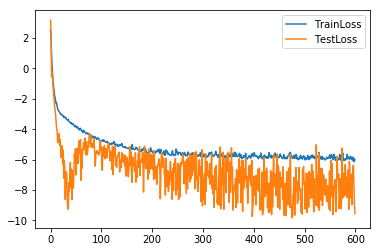

In [6]:
# Run (Train)

model = get_model(variation='mlp-regression')

history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data=(testX, testY), verbose=0, shuffle=True)

plt.plot(np.log(history.history['loss']))
plt.plot(np.log(history.history['val_loss']))
plt.legend(['TrainLoss', 'TestLoss'])
plt.show()


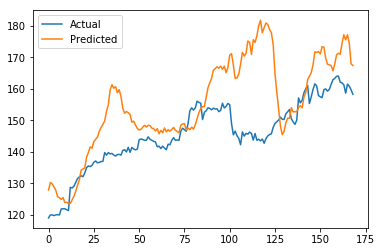

In [7]:
# Test

data = csv_as_numpy('AAPL')[1][:, 3]

data = data[-200:]

prices_actual = []
prices_predicted = []

for i in range(len(data) - window_size - 1):
        
    X = data[i: i + window_size]
    Y = data[i + window_size]
    
    X = np.array([X])
    
    mean = np.mean(X)
    
    X = X - mean
    
    std = np.std(X)
    
    X = X / std
    
    prediction = model.predict(X)
    # prediction = model.predict(np.reshape(X, (X.shape[0], 1, X.shape[1])))
    
    prediction = prediction * std + mean
    
    prices_actual.append(Y)
    prices_predicted.append(np.squeeze(prediction))

plt.plot(prices_actual)
plt.plot(prices_predicted)
plt.legend(['Actual', 'Predicted'])
plt.show()
